# Batch Rendering Brax Envs using JaxRenderer

Self-link:https://colab.research.google.com/drive/1bbrBZq2DNPoBjmKbsmZJ_1HUOI7Tg7hk

Policy Generation: https://colab.research.google.com/drive/1mD54FTbfWD_E233YQCBuJ9d-qDZUbocU

<details>
  <summary>Other benchmarks</summary>
Generate data: https://colab.research.google.com/drive/1c_83TLtb_pOt4OSlWFQgIKzA9DxdBDTp

Benchmarking using A100 on 32x32 canvas with various envs: https://colab.research.google.com/drive/1n-K33VkFdWy_rzbQrK-szmgeL61jq7lw

Benchmarking using A100 on 32x32 canvas: https://colab.research.google.com/drive/180T5YOd3HaSILWBSl2nhzRbqMXT8_oO7

Benchmarking using T4 on 32x32 canvas: https://colab.research.google.com/drive/1Z-nH_wn-QZ_BcjlwK32N3GIlh7ZyWAwF

Benchmarking using A100 on micro canvas (84x84): https://colab.research.google.com/drive/1-lToQZ3ZGAVQrnHy39JfneM9iT2HOfaT

Benchmarking using T4 on micro canvas (84x84): https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6

Benchmarking using T4 on small canvas: https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml

Benchmarking using A100 on small canvas: https://colab.research.google.com/drive/1Mr2pRetdobZdgdtNT_DJuS4YZq3-C4oY

Benchmarking using A100 on larger canvas: https://colab.research.google.com/drive/1A7PzhG3vn6oNzrWTxE5E3dmu8xQTcNnH

Benchmarking using T4, and baseline (CPU PyTinyrenderer): https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN

</details>

<details>
  <summary>Other related profiling/benchmarking Colabs</summary>

Profile with pre-generated data: https://colab.research.google.com/drive/12yNBVOdwUqUOBRgmQHF0gl8eMzzIi_BH

Previous profile version (profile branch head): https://colab.research.google.com/drive/1V7gdTY6ZYz7YhJI_LCWLZM035zSDTYoQ

Previous prfiling version: https://colab.research.google.com/drive/1BJQG38IHPaUuMKMnNeq0hjrLtqwx4OfU

All-inlines + minibatch loops: https://colab.research.google.com/drive/1NiCTOCxfU0Mvr818Zqt4y63-S20Gn8yb

All-inlines: https://colab.research.google.com/drive/1Wrt3a0yoVPhYUJYCZltFIYoELWD-ciE0

Baseline link: https://colab.research.google.com/drive/17NSjyJL_Ov9D32Mnrs7miZmjiPNf9U6l

</details>

> Majority of the code is adopted from [Brax Teams's Brax Training](https://colab.research.google.com/github/google/brax/blob/main/notebooks/training.ipynb), with minor modifications on the visualisation part.

The sample output is executed with A100, with High RAM (since this is the only configuration available).

Research supported with Cloud TPUs from [Google's TPU Research Cloud (TRC)](https://sites.research.google/trc/).

In [ ]:
#@title Install brax, jaxrenderer from PyPI
!pip install brax -qqqq
!pip install jaxrenderer -qqqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.3/639.3 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
#@title ## Imports
#@markdown **⚠️ PLEASE NOTE:**

#@markdown This colab runs best using a GPU runtime. From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

#@markdown If you have a TPU runtime, you can also consider connect to [local runtime](https://research.google.com/colaboratory/local-runtimes.html), like Google Cloud TPU VM.
#@markdown The built-in TPU runtime on Colab will not work as it only supports jax==0.3.25 while jaxrenderer requries jax>=0.4.0
#@markdown Alternatively, you may try Kaggle Notebook which provides jax>=0.4.0 and Python 3.8+.

import functools
from typing import Iterable, NamedTuple, Optional

import jax
from jax import numpy as jp
import numpy as onp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from PIL import Image

import brax
from brax import base, envs, math
from brax.io import model
from brax.training.acme import running_statistics, specs
import brax.training.agents.ppo.networks as ppo_networks
import brax.training.agents.sac.networks as sac_networks

import trimesh

from renderer import CameraParameters as Camera
from renderer import LightParameters as Light
from renderer import Model as RendererMesh
from renderer import ModelObject as Instance
from renderer import ShadowParameters as Shadow
from renderer import Renderer, UpAxis, create_capsule, create_cube, transpose_for_display

In [ ]:
#@title ## Utility Code and Constants

canvas_width: int = 84 #@param {type:"integer"}
canvas_height: int = 84 #@param {type:"integer"}

def grid(grid_size: int, color) -> jp.ndarray:
  grid = onp.zeros((grid_size, grid_size, 3), dtype=onp.single)
  grid[:, :] = onp.array(color) / 255.0
  grid[0] = onp.zeros((grid_size, 3), dtype=onp.single)
  # to reverse texture along y direction
  grid[:, -1] = onp.zeros((grid_size, 3), dtype=onp.single)
  return jp.asarray(grid)

_GROUND: jp.ndarray = grid(100, [200, 200, 200])

class Obj(NamedTuple):
  """An object to be rendered in the scene.

  Assume the system is unchanged throughout the rendering.

  col is accessed from the batched geoms `sys.geoms`, representing one geom.
  """
  instance: Instance
  """An instance to be rendered in the scene, defined by jaxrenderer."""
  link_idx: int
  """col.link_idx if col.link_idx is not None else -1"""
  off: jp.ndarray
  """col.transform.rot"""
  rot: jp.ndarray
  """col.transform.rot"""

def _build_objects(sys: brax.System) -> list[Obj]:
  """Converts a brax System to a list of Obj."""
  objs: list[Obj] = []

  def take_i(obj, i):
    return jax.tree_map(lambda x: jp.take(x, i, axis=0), obj)

  link_names: list[str]
  link_names = [n or f'link {i}' for i, n in enumerate(sys.link_names)]
  link_names += ['world']
  link_geoms: dict[str, list[Any]] = {}
  for batch in sys.geoms:
    num_geoms = len(batch.friction)
    for i in range(num_geoms):
      link_idx = -1 if batch.link_idx is None else batch.link_idx[i]
      link_geoms.setdefault(link_names[link_idx], []).append(take_i(batch, i))

  for _, geom in link_geoms.items():
    for col in geom:
      tex = col.rgba[:3].reshape((1, 1, 3))
      # reference: https://github.com/erwincoumans/tinyrenderer/blob/89e8adafb35ecf5134e7b17b71b0f825939dc6d9/model.cpp#L215
      specular_map = jax.lax.full(tex.shape[:2], 2.0)

      if isinstance(col, base.Capsule):
        half_height = col.length / 2
        model = create_capsule(
          radius=col.radius,
          half_height=half_height,
          up_axis=UpAxis.Z,
          diffuse_map=tex,
          specular_map=specular_map,
        )
      elif isinstance(col, base.Box):
        model = create_cube(
          half_extents=col.halfsize,
          diffuse_map=tex,
          texture_scaling=jp.array(16.),
          specular_map=specular_map,
        )
      elif isinstance(col, base.Sphere):
        model = create_capsule(
          radius=col.radius,
          half_height=jp.array(0.),
          up_axis=UpAxis.Z,
          diffuse_map=tex,
          specular_map=specular_map,
        )
      elif isinstance(col, base.Plane):
        tex = _GROUND
        model = create_cube(
          half_extents=jp.array([1000.0, 1000.0, 0.0001]),
          diffuse_map=tex,
          texture_scaling=jp.array(8192.),
          specular_map=specular_map,
        )
      elif isinstance(col, base.Convex):
        # convex objects are not visual
        continue
      elif isinstance(col, base.Mesh):
        tm = trimesh.Trimesh(vertices=col.vert, faces=col.face)
        model = RendererMesh.create(
            verts=tm.vertices,
            norms=tm.vertex_normals,
            uvs=jp.zeros((tm.vertices.shape[0], 2), dtype=int),
            faces=tm.faces,
            diffuse_map=tex,
        )
      else:
        raise RuntimeError(f'unrecognized collider: {type(col)}')

      i: int = col.link_idx if col.link_idx is not None else -1
      instance = Instance(model=model)
      off = col.transform.pos
      rot = col.transform.rot
      obj = Obj(instance=instance, link_idx=i, off=off, rot=rot)

      objs.append(obj)

  return objs

def _with_state(objs: Iterable[Obj], x: brax.Transform) -> list[Instance]:
  """x must has at least 1 element. This can be ensured by calling
    `x.concatenate(base.Transform.zero((1,)))`. x is `state.x`.

    This function does not modify any inputs, rather, it produces a new list of
    `Instance`s.
  """
  if (len(x.pos.shape), len(x.rot.shape)) != (2, 2):
    raise RuntimeError('unexpected shape in state')

  instances: list[Instance] = []
  for obj in objs:
    i = obj.link_idx
    pos = x.pos[i] + math.rotate(obj.off, x.rot[i])
    rot = math.quat_mul(x.rot[i], obj.rot)
    instance = obj.instance
    instance = instance.replace_with_position(pos)
    instance = instance.replace_with_orientation(rot)
    instances.append(instance)

  return instances

def _eye(sys: brax.System, state: brax.State) -> jp.ndarray:
  """Determines the camera location for a Brax system."""
  xj = state.x.vmap().do(sys.link.joint)
  dist = jp.concatenate(xj.pos[None, ...] - xj.pos[:, None, ...])
  dist = jp.linalg.norm(dist, axis=1).max()
  off = jp.array([2 * dist, -2 * dist, dist])

  return state.x.pos[0, :] + off

def _up(unused_sys: brax.System) -> jp.ndarray:
  """Determines the up orientation of the camera."""
  return jp.array([0., 0., 1.])

def get_target(state: brax.State) -> jp.ndarray:
  """Gets target of camera."""
  return jp.array([state.x.pos[0, 0], state.x.pos[0, 1], 0])

def get_camera(
    sys: brax.System,
    state: brax.State,
    width: int = canvas_width,
    height: int = canvas_height,
) -> Camera:
  """Gets camera object."""
  eye, up = _eye(sys, state), _up(sys)
  hfov = 58.0
  vfov = hfov * height / width
  target = get_target(state)
  camera = Camera(
      viewWidth=width,
      viewHeight=height,
      position=eye,
      target=target,
      up=up,
      hfov=hfov,
      vfov=vfov,
  )

  return camera

## Experiment

In [ ]:
#@title ### Download Generated Policy

!wget -q https://github.com/JoeyTeng/jaxrenderer/releases/download/v0.3.1/brax-env-params-positional.zip -O policies.zip
!rm -rf params_* 2>&1 >/dev/null
!unzip -q policies.zip

In [ ]:
#@title ### Setup Env and Policy

env_name = 'ant'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'

frames_to_render_per_env: int = 90  # @param {type:"slider", min:1, max:300, step:1}
envs_to_simulate: int = 30  # @param {type:"slider", min:1, max:100, step:1}
seed: int = 20230627 # @param {type:"integer"}
seed_key = jax.random.PRNGKey(seed=seed)
ret = jax.jit(jax.random.split, static_argnames=("num", ))(seed_key, num=envs_to_simulate + 1)
seed_key = ret[0]
seed_keys = ret[1:]

env: envs.Env = envs.create(env_name=env_name, backend=backend)
states: brax.State = jax.jit(jax.vmap(env.reset))(seed_keys)
del seed_keys

def gen_make_policy_fn(module):
  """Reference
  - https://github.com/google/brax/blob/ac2b94bad71658a2cc194518c6585c11117663fe/brax/training/agents/sac/train.py#L177
  - https://github.com/google/brax/blob/ac2b94bad71658a2cc194518c6585c11117663fe/brax/training/agents/ppo/train.py#L151C1-L151C1
  """
  import inspect as _i

  _module_members = dict(_i.getmembers(module))
  _name = next(filter(lambda name: name.startswith("make_") and name.endswith("_networks"), _module_members.keys()))
  _network_factory = _module_members[_name]

  del _module_members
  del _name

  def f(env: envs.Env):
    network = _network_factory(
        observation_size=env.observation_size,
        action_size=env.action_size,
        # preprocess_observations_fn=lambda x, y: x,
        preprocess_observations_fn=running_statistics.normalize,
    )

    return module.make_inference_fn(network)

  return f

make_policy_fn = {
  'inverted_pendulum': gen_make_policy_fn(ppo_networks),
  'inverted_double_pendulum': gen_make_policy_fn(ppo_networks),
  'ant': gen_make_policy_fn(ppo_networks),
  'humanoid': gen_make_policy_fn(ppo_networks),
  'reacher': gen_make_policy_fn(ppo_networks),
  'humanoidstandup': gen_make_policy_fn(ppo_networks),
  'hopper': gen_make_policy_fn(sac_networks),
  'walker2d': gen_make_policy_fn(sac_networks),
  'halfcheetah': gen_make_policy_fn(ppo_networks),
  'pusher': gen_make_policy_fn(ppo_networks),
}[env_name]

make_policy = make_policy_fn(env)
model_params = model.load_params(f'params_{env_name}')
inference_fn = make_policy(model_params)

In [ ]:
#@title ### Render function

@jax.default_matmul_precision("float32")
def render_instances(
  instances: list[Instance],
  width: int,
  height: int,
  camera: Camera,
  light: Optional[Light] = None,
  shadow: Optional[Shadow] = None,
  camera_target: Optional[jp.ndarray] = None,
  enable_shadow: bool = True,
) -> jp.ndarray:
  """Renders an RGB array of sequence of instances.

  Rendered result is not transposed with `transpose_for_display`; it is in
  floating numbers in [0, 1], not `uint8` in [0, 255].
  """
  if light is None:
    direction = jp.array([0.57735, -0.57735, 0.57735])
    light = Light(
        direction=direction,
        ambient=0.8,
        diffuse=0.8,
        specular=0.6,
    )
  if shadow is None and enable_shadow:
    assert camera_target is not None, 'camera_target is None'
    shadow = Shadow(centre=camera_target)
  elif not enable_shadow:
    shadow = None

  img = Renderer.get_camera_image(
    objects=instances,
    light=light,
    camera=camera,
    width=width,
    height=height,
    shadow_param=shadow,
  )
  arr = jax.lax.clamp(0., img, 1.)

  return arr

def gen_compile_render(sys: brax.System, states: brax.State):
  """Return batched states."""
  # build inputs
  get_cameras = jax.jit(jax.vmap(lambda state: get_camera(sys, state)))
  batched_camera = get_cameras(states)
  get_targets = jax.jit(jax.vmap(get_target))
  batched_target = get_targets(states)

  objs = _build_objects(sys)


  def render(states: brax.State) -> jp.ndarray:
    get_instances = jax.jit(jax.vmap(lambda state: _with_state(objs, state.x.concatenate(base.Transform.zero((1,))))))
    batched_instances = get_instances(states)

    def _render(instances, camera, target) -> jp.ndarray:
      _render = jax.jit(
        render_instances,
        static_argnames=("width", "height", "enable_shadow"),
        inline=True,
      )
      img = _render(instances=instances, width=canvas_width, height=canvas_height, camera=camera, camera_target=target)
      arr = transpose_for_display((img * 255).astype(jp.uint8))

      return arr

    # render
    _render_batch = jax.jit(jax.vmap(_render))
    images = _render_batch(batched_instances, batched_camera, batched_target)

    return images

  def copy_back_images(images: jp.ndarray) -> list[Image.Image]:
    # copy back
    images_in_device = jax.device_get(images)

    np_arrays: Iterable[onp.ndarray] = map(onp.asarray, images_in_device)
    frames: list[Image.Image] = [Image.fromarray(arr) for arr in np_arrays]

    return frames


  render_compiled = jax.jit(render).lower(states).compile()

  def wrap(states: brax.State) -> list[Image.Image]:
    images = render_compiled(states)

    return copy_back_images(images)

  return wrap

In [ ]:
#@title ### Compile
# warmup
print("Compile and generate rendering function")
render_with_states = %time gen_compile_render(env.sys.replace(dt=env.dt), states.pipeline_state)
print()
print("Render time")
%time render_with_states(states.pipeline_state)

print()
print("Compile jax.random.split")
split_compiled = %time jax.jit(jax.random.split, static_argnames=("num", )).lower(seed_key, envs_to_simulate + 1).compile()

_ret = split_compiled(seed_key)

print()
print("Compile inference function")
inference_compiled = %time jax.jit(jax.vmap(inference_fn)).lower(states.obs, _ret[1:]).compile()
print()
print("Inference time")
_acts, _ = %time inference_compiled(states.obs, _ret[1:])

print()
print("Compile step function")
env_step_compiled = %time jax.jit(jax.vmap(env.step)).lower(states, _acts).compile()
print()
print("Step time")
%time env_step_compiled(states, _acts)
del _ret
del _acts

Compile and generate rendering function
CPU times: user 17 s, sys: 1.36 s, total: 18.4 s
Wall time: 17 s

Render time
CPU times: user 19.7 ms, sys: 2.31 ms, total: 22 ms
Wall time: 74.2 ms

Compile jax.random.split
CPU times: user 65.9 ms, sys: 1.88 ms, total: 67.8 ms
Wall time: 59.8 ms

Compile inference function
CPU times: user 681 ms, sys: 27.4 ms, total: 708 ms
Wall time: 425 ms

Inference time
CPU times: user 4.33 ms, sys: 87 µs, total: 4.42 ms
Wall time: 3.53 ms

Compile step function
CPU times: user 16.6 s, sys: 214 ms, total: 16.8 s
Wall time: 13.7 s

Step time
CPU times: user 13 ms, sys: 1.12 ms, total: 14.1 ms
Wall time: 12.3 ms


In [ ]:
%%time
#@title ### Render

images: list[list[Image.Image]] = [[] for _ in range(envs_to_simulate)]
for _ in range(frames_to_render_per_env):
  # render a batch of one action
  frames = render_with_states(states.pipeline_state)
  for frame, image_list in zip(frames, images):
    image_list.append(frame)

  # simulate next action
  ret = split_compiled(seed_key)
  seed_key = ret[0]
  seed_keys = ret[1:]

  acts, _ = inference_compiled(states.obs, seed_keys)
  states = env_step_compiled(states, acts)

CPU times: user 1.98 s, sys: 113 ms, total: 2.09 s
Wall time: 1.91 s


In [ ]:
#@title ### Plot
fig, axs = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True, figsize=(15, 18))

frames = []
for f in range(frames_to_render_per_env):
  per_frame = []
  for i in range(envs_to_simulate):
    ax = axs[i // 5][i % 5]

    im = ax.imshow(onp.asarray(images[i][f]))
    per_frame.append(im)

  frames.append(per_frame)

print("frames:", len(frames))

ani = animation.ArtistAnimation(
    fig,
    frames,
    interval=1, # 1fps
    blit=True,
    repeat=True,
    repeat_delay=0,
)

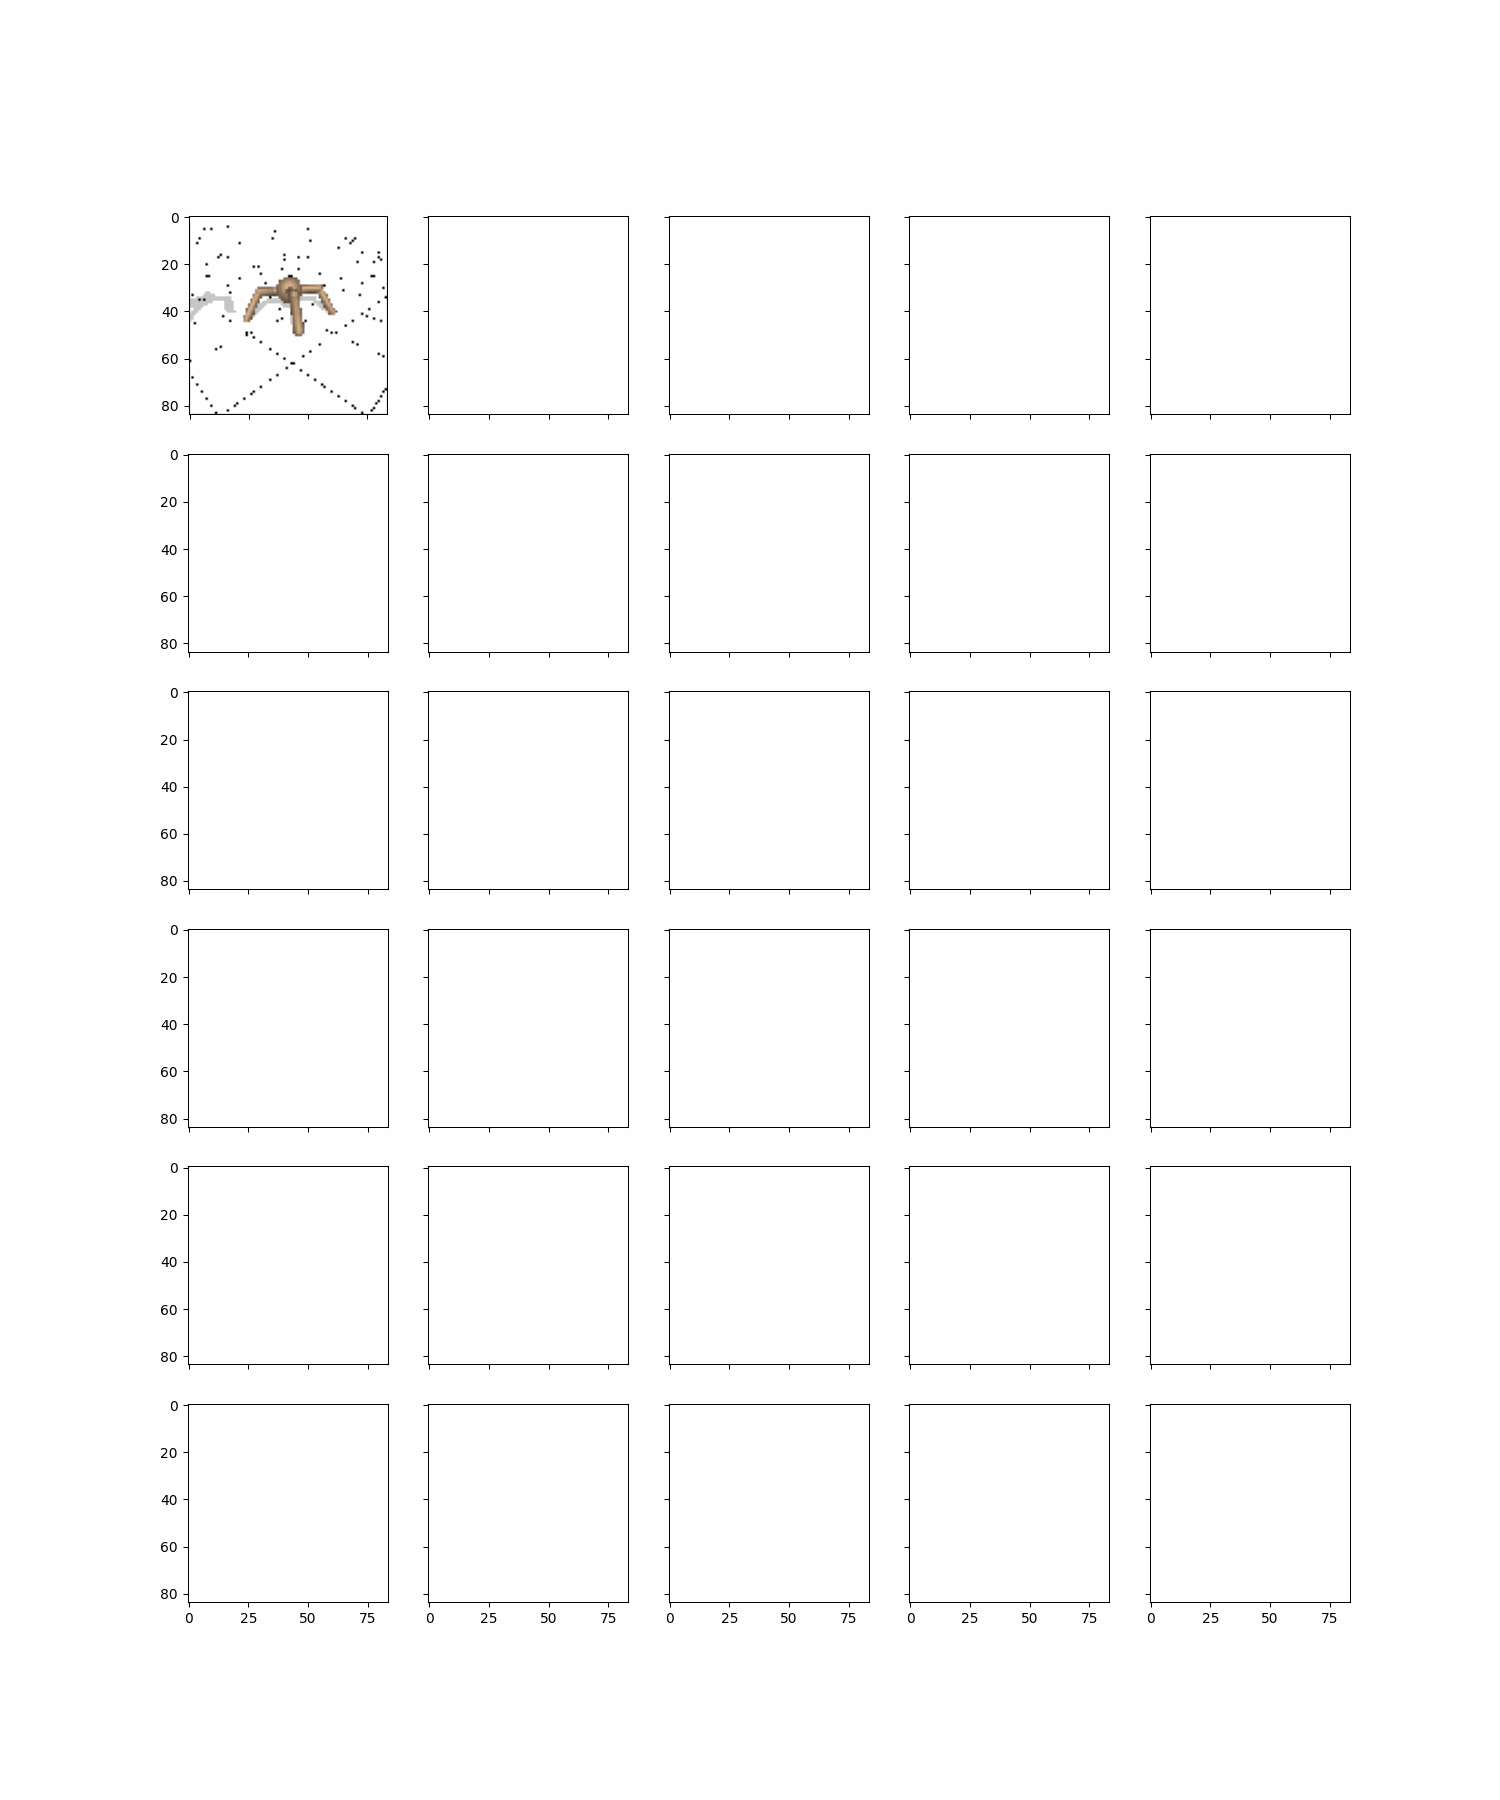

In [ ]:
#@title #### Save to disk and show
from IPython.display import Image
ani.save('animation.gif', writer='pillow', fps=30)
Image(filename='animation.gif')

In [ ]:
#@title Terminating Colab Automatically
try:
  from google.colab import runtime
  print("Terminating Colab")
  runtime.unassign()
except ModuleNotFoundError:
  print("Not in Colab, skip termination")